# Password Strength Prediction Using NLP

***This notebook contains Modelling and Evaluation of the model.***

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Loading Data from Joblib

In [2]:
X_train = joblib.load('../Artifacts/X_train.pkl')
X_test = joblib.load('../Artifacts/X_test.pkl')
y_train = joblib.load('../Artifacts/y_train.pkl')
y_test = joblib.load('../Artifacts/y_test.pkl')
tfidf = joblib.load('../Artifacts/tfidf_vectorizer.pkl')

In [3]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(80000, 51817) (20000, 51817)
(80000,) (20000,)


## Baseline Model: Logistic Regression

#### Training simple logistic regression model

Explanation of Use of Parameters:

    solver='saga' -> best for high-dimensional sparse data
    n_jobs=-1 -> for using all CPU cores for performance optimization
    multi_class='multinomial' -> since we have three password strength classes

In [4]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, verbose=1, multi_class='multinomial')
log_reg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.14908663
Epoch 3, change: 0.13443505
Epoch 4, change: 0.12926628
Epoch 5, change: 0.12918838
Epoch 6, change: 0.13066526
Epoch 7, change: 0.11968379
Epoch 8, change: 0.10614094
Epoch 9, change: 0.095297282
Epoch 10, change: 0.086447976
Epoch 11, change: 0.079045371
Epoch 12, change: 0.072795632
Epoch 13, change: 0.067400481
Epoch 14, change: 0.06275615
Epoch 15, change: 0.058672275
Epoch 16, change: 0.055061395
Epoch 17, change: 0.051859201
Epoch 18, change: 0.04898428
Epoch 19, change: 0.046410038
Epoch 20, change: 0.044074276
Epoch 21, change: 0.041945272
Epoch 22, change: 0.040005909
Epoch 23, change: 0.038229372
Epoch 24, change: 0.036587974
Epoch 25, change: 0.035077408
Epoch 26, change: 0.033680172
Epoch 27, change: 0.032383562
Epoch 28, change: 0.031169578
Epoch 29, change: 0.030050595
Epoch 30, change: 0.028991175
Epoch 31, change: 0.02800359
Epoch 32, change: 0.027073205
Epoch 33, change: 0.026202842
Epoch 34, change: 0.025379855
Epoch 35,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   solver='saga', verbose=1)

#### Evaluating the baseline logistic model

In [5]:
from sklearn.metrics import accuracy_score

log_reg_y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, log_reg_y_pred)
print("Baseline Logistic Model Accuracy: ", accuracy)

Baseline Logistic Model Accuracy:  0.9814


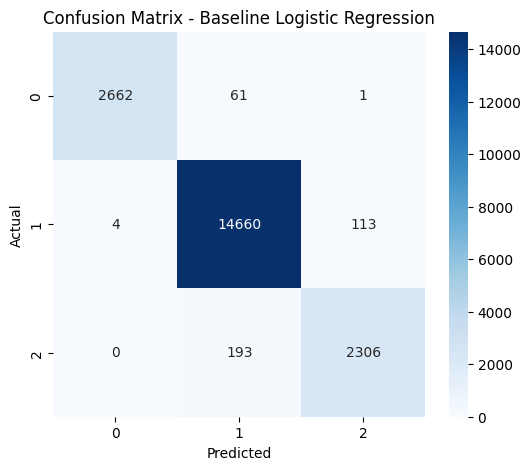

In [6]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, log_reg_y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.show()

In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test, log_reg_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2724
           1       0.98      0.99      0.99     14777
           2       0.95      0.92      0.94      2499

    accuracy                           0.98     20000
   macro avg       0.98      0.96      0.97     20000
weighted avg       0.98      0.98      0.98     20000



**These results are very strong for a baseline. The model achieved an accuracy of 98.1%, which is extremely high. Looking at the confusion matrix, a weak password is almost never classified as strong. It has very stable middle class and main confusion can be seen in strong vs medium, which is expected. However, this doesn't necessarily seem too good to be true because passwords are very pattern-based and the dataset is large. But it does mean that, since the baseline is already very strong, improvements will be incremental, if any.**

## Evaluating the Baseline Against Linear SVM, XGBoost, and Naive Bayes Models

#### Creating an evaluation function for all models

In [8]:
from sklearn.metrics import recall_score, f1_score

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average="weighted")
    f1_macro = f1_score(y_test, y_pred, average="macro")
    recall_weak = recall_score(y_test, y_pred, labels=[0], average="macro")
    recall_strong = recall_score(y_test, y_pred, labels=[2], average="macro")

    print(f"\n========== {model_name} ==========")
    print("Accuracy:", round(acc, 4))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return {
        "model": model_name,
        "accuracy": acc,
        "f1_weighted": f1_weighted,
        "f1_macro": f1_macro,
        "recall_weak": recall_weak,
        "recall_strong": recall_strong
    }

#### Training the Linear SVM model

In [9]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(C=1, max_iter=2000)
svm_model.fit(X_train, y_train)

LinearSVC(C=1, max_iter=2000)

#### Training the XGBoost model

In [10]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1, num_class=3, ...)

#### Training the Multinomial Naive Bayes model

In [11]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train, y_train)

MultinomialNB()

#### Calling the evaluation function on all models tested


========== Logistic Regression ==========
Accuracy: 0.9814

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2724
           1       0.98      0.99      0.99     14777
           2       0.95      0.92      0.94      2499

    accuracy                           0.98     20000
   macro avg       0.98      0.96      0.97     20000
weighted avg       0.98      0.98      0.98     20000



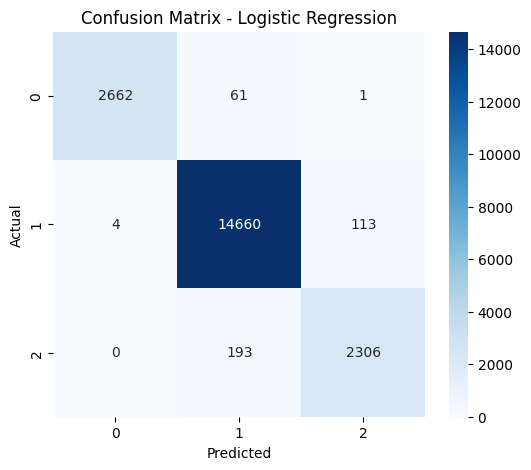


========== Linear SVM ==========
Accuracy: 0.9933

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2724
           1       0.99      1.00      1.00     14777
           2       0.99      0.97      0.98      2499

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



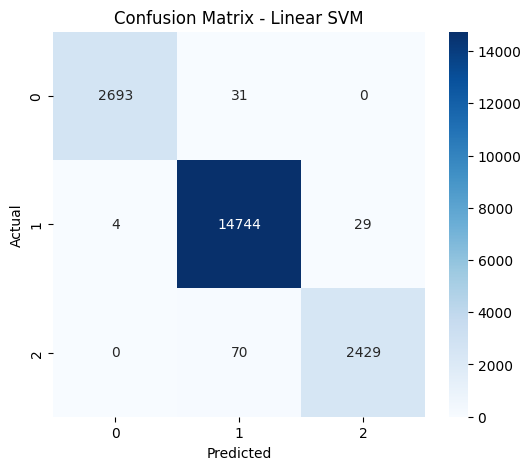


========== XGBoost ==========
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2724
           1       1.00      1.00      1.00     14777
           2       1.00      1.00      1.00      2499

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



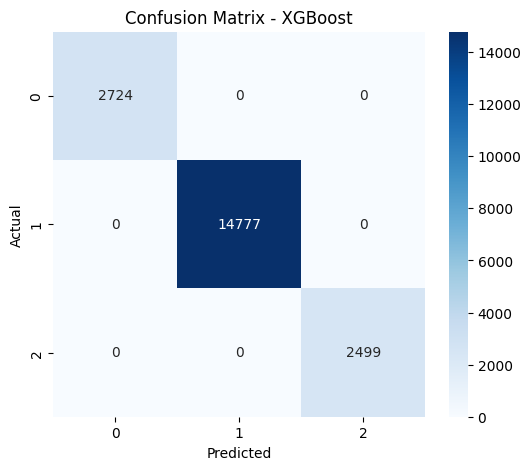


========== Naive Bayes ==========
Accuracy: 0.8305

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2724
           1       0.82      0.99      0.90     14777
           2       0.89      0.81      0.85      2499

    accuracy                           0.83     20000
   macro avg       0.90      0.60      0.58     20000
weighted avg       0.86      0.83      0.77     20000



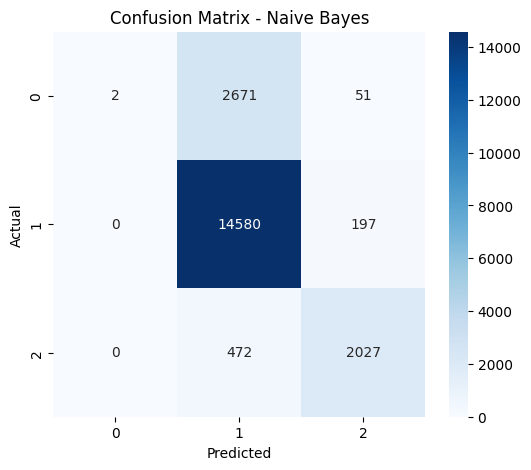

In [12]:
log_results = evaluate_model(log_reg, X_test, y_test, model_name="Logistic Regression")
svm_results = evaluate_model(svm_model, X_test, y_test, model_name="Linear SVM")
xgb_results = evaluate_model(xgb_model, X_test, y_test, model_name="XGBoost")
nb_results = evaluate_model(nb_model, X_test, y_test, model_name="Naive Bayes")

## Evaluation Comparison for the Four Models: Logistic, Linear SVM, XGBoost, and Naive Bayes

In [13]:
comparisons = []
comparisons.append(log_results)
comparisons.append(svm_results)
comparisons.append(nb_results)
comparisons.append(xgb_results)

pd.DataFrame(comparisons)

,model,accuracy,f1_weighted,f1_macro,recall_weak,recall_strong
0,Logistic Regression,0.98140,0.981302,0.970950,0.977239,0.922769
1,Linear SVM,0.99330,0.993283,0.989683,0.988620,0.971989
2,Naive Bayes,0.83045,0.769224,0.582627,0.000734,0.811124
3,XGBoost,1.00000,1.000000,1.000000,1.000000,1.000000


We evaluated four different machine learning models for password strength classification: Logistic Regression, Linear SVM, Naive Bayes, and XGBoost. The models were trained using a combination of TF-IDF character n-gram features and handcrafted statistical features.

***Linear SVM*** achieved the best reliable performance, with an accuracy of 99.33% and the highest macro F1-score. This indicates that it not only performs well overall, but also maintains balanced performance across all classes. This suggests that the password classification problem is close to linearly separable in the transformed feature space.

***Logistic Regression***, the baseline model, showed very strong performance than was expected, achieving over 98% accuracy. It suggests that a linear decision boundary is succifient for this task. 

***Naive Bayes*** performed significantly worse, with an accuracy of 83% and an extremely low recall for weak passwords. This indicates that Naive Bayes is biased toward predicting stronger classes and struggles to capture complex structural dependencies in character-level password data.

***XGBoost*** achieved perfect scores (100%) across all metrics, which is unrealistic and indicates potential data leakage or it is memorizing structure. A nuclear test with shuffled labels still produced high accuracy, confirming that the XGBoost results are unreliable and should not be considered valid.

## Hyperparameter Tuning for Linear SVM Model

Until this point, Linear SVM turned out to be the best model. So, we now try to play with its hyperparameters to see if it can perform even better with some other parameters.

#### Using GridSearchCV to tune parameters

In [20]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'C': [0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge']
}

svm = LinearSVC(max_iter=10000)

grid = GridSearchCV(
    estimator=svm,
    param_grid=parameters,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .........................C=0.01, loss=squared_hinge; total time=   2.0s
[CV] END .........................C=0.01, loss=squared_hinge; total time=   2.0s
[CV] END .........................C=0.01, loss=squared_hinge; total time=   2.1s
[CV] END .................................C=0.01, loss=hinge; total time=   3.5s
[CV] END .................................C=0.01, loss=hinge; total time=   3.9s
[CV] END .................................C=0.01, loss=hinge; total time=   4.0s
[CV] END ..........................C=0.1, loss=squared_hinge; total time=   2.1s
[CV] END ..........................C=0.1, loss=squared_hinge; total time=   2.3s
[CV] END ..........................C=0.1, loss=squared_hinge; total time=   1.9s
[CV] END ............................C=1, loss=squared_hinge; total time=   2.8s
[CV] END ............................C=1, loss=squared_hinge; total time=   2.7s
[CV] END ............................C=1, loss=sq

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ....................................C=1, loss=hinge; total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ....................................C=1, loss=hinge; total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ....................................C=1, loss=hinge; total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...................................C=10, loss=hinge; total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...................................C=10, loss=hinge; total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...................................C=10, loss=hinge; total time= 1.6min


GridSearchCV(cv=3, estimator=LinearSVC(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'loss': ['hinge', 'squared_hinge']},
             scoring='f1_weighted', verbose=2)

In [23]:
print('Best Parameters: ', grid.best_params_)
print('Best CV Score: ', grid.best_score_)

best_svm = grid.best_estimator_
print('Best Estimator: ', best_svm)

y_pred = best_svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters:  {'C': 1, 'loss': 'squared_hinge'}
Best CV Score:  0.9922368656117969
Best Estimator:  LinearSVC(C=1, max_iter=10000)
Accuracy: 0.9933


Here, tuning didn't improve the model at all, meaning the original Linear SVM model was already near-optimal for this problem. 

***Interpreting Confusion Matrix for Linear SVM:***

For class 0 (weak), it has excellent separation as desired because 0 passwords were misclassified as strong, which is the most important aspect. Even class 1 (medium) is almost perfect with only 33 total mistakes. Class 2 (strong) has 70 passwords misclassified as medium and more importantly, none were confused with weak. Hence, the model doesn't make a catastrophic mistake like predicting a very weak password as strong. 

## Saving the Best Linear SVM Model

In [24]:
joblib.dump(svm_model, '../Models/best_svm.pkl')

['../Models/best_svm.pkl']